In [1]:
from vq_gan_3d.model.vqgan import Encoder, SamePadConv3d
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-dark")
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from omegaconf import DictConfig, open_dict

import torch.nn.functional as F
from scipy.spatial.distance import cdist
import nibabel as nib
from skimage import exposure
from sklearn.manifold import MDS

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

import SimpleITK as sitk

import scipy
import glob2
import os, re
import multiprocessing
import scipy.stats


In [3]:
#load training data+augmented versions
from dataset.mrnet_contrastive_pairs import MRNetDatasetContrastivePairs
data = 'mrnet'
if data =='mrnet':
    data_path = 'data/MRNet-v1.0/'
    dataset = MRNetDatasetContrastivePairs(data_path, task = 'acl', plane = 'sagittal',split='train')
    datasetval = MRNetDatasetContrastivePairs(data_path , task = 'acl', plane = 'sagittal',split='valid')

NumSamples = dataset.__len__()


In [4]:
#Load model
exp = 'exp_journal'
class Model(nn.Module):
    def __init__(self, data=data):
        super().__init__()
        self.conv_only = False
        self.sup_training = False
        self.data= data
        if self.data=='mrnet':
            self.downsample= [8, 64, 64] 
        self.n_hiddens= 16 # number of hidden units
        self.image_channel = 1
        self.embedding_dim=8 
        self.encoder = Encoder(downsample = self.downsample, n_hiddens=self.n_hiddens, image_channel=self.image_channel)
        self.enc_out_ch = self.encoder.out_channels

        self.conv3D = SamePadConv3d(self.enc_out_ch, self.embedding_dim, 1)

        self.dense = nn.Sequential(nn.Flatten(),
                                nn.Linear(self.embedding_dim * 4**3, 128),
                                nn.ReLU(inplace=True),
                                nn.Dropout(0.5),
                                nn.Linear(128,32))
        self.sup_layer = nn.Sequential(nn.ReLU(inplace=True),
                            nn.Linear(32,1))
    def forward(self, x):
        x = self.encoder(x)
        h = self.conv3D(x)
        if not(self.conv_only):
            h = self.dense(h)
            fin = None
        return h, fin

model = Model(data= data)
#load saved model
if data =='mrnet':
    model.load_state_dict(torch.load('ckpt/'+exp+'/model'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

Model(
  (encoder): Encoder(
    (conv_blocks): ModuleList(
      (0): Module(
        (down): SamePadConv3d(
          (conv): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
        (res): ResBlock(
          (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
          (conv1): SamePadConv3d(
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
          (conv2): SamePadConv3d(
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
          )
        )
      )
      (1): Module(
        (down): SamePadConv3d(
          (conv): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2))
        )
        (res): ResBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv1): SamePadConv3d(
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
          )
    

In [5]:

#load synthetic data
def LoadData(Dir = 'data/meddiff/', Samples = 500):
    DatasetSynthetic =[]
    files = glob2.glob(Dir+'/*nii*')
    for ii in range(Samples):
        Tmp = nib.load(files[ii])
        Tmp = np.asanyarray(Tmp.dataobj)   
        Tmp = (Tmp-np.min(Tmp))/(np.max(Tmp)-np.min(Tmp)+1e-4)
        Tmp = 2*Tmp-1          
        DatasetSynthetic.append(Tmp) 
    DatasetSynthetic = np.array(DatasetSynthetic)   
    return DatasetSynthetic    

#calculate embeddings
def CalEmeddings (model, Data):
    Embeddings = []
    for ii in range(Data.shape[0]):
        with torch.no_grad(): 
            Tmp = Data[ii].copy()
            Tmp = (Tmp-np.min(Tmp))/(np.max(Tmp)-np.min(Tmp)+1e-4)
            Tmp = 2*Tmp-1   
            
            Tmp = torch.from_numpy(Tmp).float()
            Tmp = model(Tmp.to(device).unsqueeze(0).unsqueeze(0).to(device))[0]
            Embeddings.append(Tmp.cpu().numpy().flatten()) 
    Embeddings = np.array(Embeddings)
    return Embeddings 

In [6]:
Nsamples = NumSamples# 904 for MRNet
if data =='mrnet':
    Dir1 =  'data/meddiff/' 
    Dir2 = 'data/monai/'   
    
DatasetSynthetic1 = LoadData(Dir = Dir1, Samples=Nsamples)
DatasetSynthetic2 = LoadData(Dir = Dir2, Samples=Nsamples)
if data =='mrnet':
    DatasetSynthetic2 = np.transpose(DatasetSynthetic2, axes=(0,3,1,2))

In [7]:
DatasetSynthetic2 = LoadData(Dir = Dir2, Samples=Nsamples)
if data =='mrnet':
    DatasetSynthetic2 = np.transpose(DatasetSynthetic2, axes=(0,3,1,2))

In [8]:
torch.cuda.empty_cache()
Embeddings = []
#Embeddings for real training adata
for ii in range(dataset.__len__()):
    with torch.no_grad():

        Tmp = dataset.__getitem__( ii)['data2']
        Tmp = (Tmp-Tmp.min())/(Tmp.max()-Tmp.min()+1e-4)
        Tmp = 2*Tmp-1         
        Tmp = model(torch.unsqueeze(Tmp, dim =0).to(device))[0]
        Embeddings.append(Tmp.cpu().numpy().flatten())
Embeddings = np.array(Embeddings)

EmbeddingsVal = []
#Embeddings for real validation adata
for ii in range(datasetval.__len__()):
    with torch.no_grad():

        Tmp = datasetval.__getitem__( ii)['data2']
        Tmp = (Tmp-Tmp.min())/(Tmp.max()-Tmp.min()+1e-4)
        Tmp = 2*Tmp-1         
        Tmp = model(torch.unsqueeze(Tmp, dim =0).to(device))[0]
        EmbeddingsVal.append(Tmp.cpu().numpy().flatten())
EmbeddingsVal = np.array(EmbeddingsVal)


In [9]:

#Embeddings for synthetic
EmbeddingsSyn1 = CalEmeddings(model, DatasetSynthetic1)
EmbeddingsSyn2 = CalEmeddings(model, DatasetSynthetic2)


In [10]:
#Compare training and syntheszed samples computer differences


loss_type = 'correlation'
RealRealDiff =cdist (Embeddings, Embeddings,loss_type)
RealValDiff =cdist (Embeddings, EmbeddingsVal,loss_type)
RealTrnDiff =cdist (Embeddings, Embeddings,loss_type)

RealSynDiff1 =cdist (Embeddings, EmbeddingsSyn1,loss_type )
RealSynDiff2 =cdist (Embeddings, EmbeddingsSyn2,loss_type)

ValSynDiff =cdist (EmbeddingsVal, EmbeddingsSyn1,loss_type )
SynRealDiff1 = cdist (EmbeddingsSyn1, Embeddings,loss_type )
SynRealDiff2 = cdist (EmbeddingsSyn2, Embeddings,loss_type )


RealSynDiffSorted1Idx = np.argsort(RealSynDiff1, axis = -1)
RealSynDiffSorted1 = np.sort(RealSynDiff1, axis = -1)
RealSynDiffSorted1Idx2 = np.argsort(RealSynDiffSorted1[:,0])

RealSynDiffSorted2Idx = np.argsort(RealSynDiff2, axis = -1)
RealSynDiffSorted2 = np.sort(RealSynDiff2, axis = -1)
RealSynDiffSorted2Idx2 = np.argsort(RealSynDiffSorted2[:,0])

RealRealDiffSortedIdx = np.argsort(RealRealDiff, axis = -1)
RealRealDiffSorted = np.sort(RealRealDiff, axis = -1)

RealValDiffSortedIdx = np.argsort(RealValDiff, axis = -1)
RealValDiffSorted = np.sort(RealValDiff, axis = -1)

RealTrnDiffSortedIdx = np.argsort(RealTrnDiff, axis = -1)
RealTrnDiffSorted = np.sort(RealTrnDiff, axis = -1)

ValSynDiffSortedIdx = np.argsort(ValSynDiff, axis = -1)
ValSynDiffSorted = np.sort(ValSynDiff, axis = -1)

SynRealDiffSorted1Idx = np.argsort(SynRealDiff1, axis = -1)
SynRealDiffSorted1 = np.sort(SynRealDiff1, axis = -1)

SynRealDiffSorted2Idx = np.argsort(SynRealDiff2, axis = -1)
SynRealDiffSorted2= np.sort(SynRealDiff2, axis = -1)

In [11]:

Thr = np.percentile(RealValDiffSorted[:, 0], 5) 
prctl = 1 - Thr


print(prctl)
print('Training samples that are copies (Med diffusion): '+str(np.sum(RealSynDiffSorted1[:, 0]<Thr)) +' and '+ str(np.sum(RealSynDiffSorted1[:, 0]<Thr)/NumSamples*100))
print('Synthetic samples that are copies (Med diffusion): '+str(np.sum(SynRealDiffSorted1[:, 0]<Thr))+' and '+ str(np.sum(SynRealDiffSorted1[:, 0]<Thr)/NumSamples*100))
#print('Validation samples that are copies: '+str(np.sum(ValSynDiffSorted[:, 0]<Thr))+ ' and '+ str(np.sum(ValSynDiffSorted[:, 0]<Thr)/NumSamples*100))

print('Training samples that are copies (Monai): '+str(np.sum(RealSynDiffSorted2[:, 0]<Thr)) +' and '+ str(np.sum(RealSynDiffSorted2[:, 0]<Thr)/NumSamples*100))
print('Synthetic samples that are copies (Monai): '+str(np.sum(SynRealDiffSorted2[:, 0]<Thr))+' and '+ str(np.sum(SynRealDiffSorted2[:, 0]<Thr)/NumSamples*100))



0.9296025317737231
Training samples that are copies (Med diffusion): 363 and 40.15486725663717
Synthetic samples that are copies (Med diffusion): 688 and 76.10619469026548
Training samples that are copies (Monai): 436 and 48.23008849557522
Synthetic samples that are copies (Monai): 790 and 87.38938053097345


/tmp/ipykernel_2468225/465458565.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  aa = sns.distplot( 1 - RealSynDiffSorted1[0:Nsamples, 0] ,hist= True,  kde_kws={'clip': (0.0, 1.0), 'linewidth' :linewidth}, label="MedDiff",  kde = True, bins = bins, fit_kws={'color':"blue"} )
/tmp/ipykernel_2468225/465458565.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/m

Text(0.8552343292318253, 7.680709754614947, '$\\tau$ = 0.93')

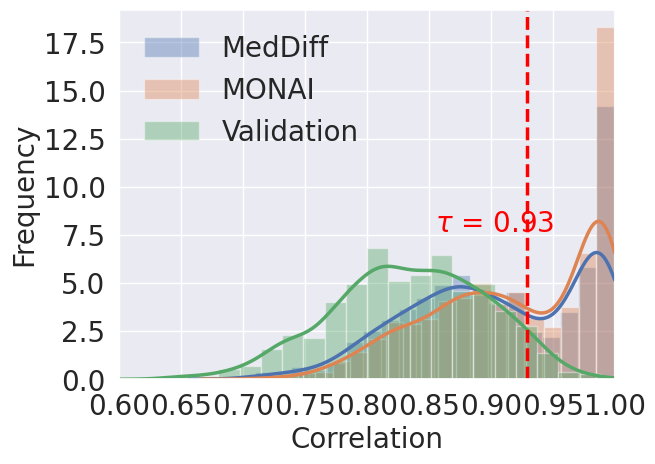

In [14]:

import seaborn as sns

bins = 20
fontsize = 20
linewidth = 2.5
sns.set_theme()
aa = sns.distplot( 1 - RealSynDiffSorted1[0:Nsamples, 0] ,hist= True,  kde_kws={'clip': (0.0, 1.0), 'linewidth' :linewidth}, label="MedDiff",  kde = True, bins = bins, fit_kws={'color':"blue"} )
bb = sns.distplot( 1 - RealSynDiffSorted2[0:Nsamples, 0] ,hist= True,  kde_kws={'clip': (0.0, 1.0), 'linewidth' :linewidth},label="MONAI",  kde = True, bins = bins, fit_kws={'color':"green"} )
cc = sns.distplot( 1 - RealValDiffSorted[0:Nsamples, 0], hist= True, kde_kws={'clip': (0.0, 1.0), 'linewidth' :linewidth},label="Validation", kde = True, bins = bins, fit_kws={'color':"red"})

plt.axvline(prctl, color='red', linestyle='dashed',linewidth=linewidth)

min_ylim, max_ylim = plt.ylim()


plt.xlabel('Correlation', fontsize=fontsize);plt.ylabel('Frequency', fontsize=fontsize)
plt.legend( fontsize=fontsize); #plt.ylim((0,34)); #
if data=='pccta':
    plt.xlim((0.25,1))
else:
    plt.xlim((0.6,1))
plt.xticks(fontsize=fontsize);plt.yticks(fontsize=fontsize)
plt.text(prctl*0.92, max_ylim*0.4, r'$\tau$ = {:.2f}'.format(prctl), fontsize=fontsize, color = "red")




In [13]:
SharedCopies = np.intersect1d(RealSynDiffSorted1Idx2[0:100],RealSynDiffSorted2Idx2[0:100])
Indices1 = np.where(np.in1d(RealSynDiffSorted1Idx2, SharedCopies))[0]
Indices2 = np.where(np.in1d(RealSynDiffSorted2Idx2, SharedCopies))[0]
print(np.take(RealSynDiffSorted1Idx2, SharedCopies))

[526 809 267 104 674 872 709 687 441 328 850 523 602 202 745 786  14]


In [ ]:
#Save some of the copies that are present in both meddiff and monai synthesized samples
SaveDir = 'results/'+exp+'/'
#save gifs of real and synthesized
from einops import rearrange
from ddpm.diffusion import video_tensor_to_gif
if data=='pccta':
    SubSamples = np.linspace(0,62,6, dtype=int)
else:
    SubSamples = np.linspace(6,24,6, dtype=int)
RealSamples = []; SynthSamples= []
for idx, ii in enumerate(SharedCopies[:10]):
    jj = np.where(ii==RealSynDiffSorted1Idx2)[0][0]
    with torch.no_grad():

        Tmp = dataset.__getitem__( ii)['data2']
        Tmp = (Tmp-Tmp.min())/(Tmp.max()-Tmp.min()+1e-4)
        Tmp = 2*Tmp-1  
        Tmp = F.pad(Tmp, (2, 2, 2, 2))
        RealSamples.append(Tmp)
        Tmp = Tmp[0, SubSamples, :] 
        Tmp = np.transpose(Tmp,axes = (0,2,1))       
        if data == 'mrnet':
            Tmp = np.transpose(Tmp,axes = (0,2,1))
            Tmp = torch.clamp(Tmp, min = torch.quantile(Tmp, .01),  max = torch.quantile(Tmp,0.99))
        SampleReal = np.reshape(Tmp, (Tmp.shape[0]*Tmp.shape[1],Tmp.shape[2]))

        
        Tmp = torch.from_numpy(DatasetSynthetic1[[RealSynDiffSorted1Idx[ii,0]],:]).float()
        #Tmp = torch.clamp(Tmp, min = torch.quantile(Tmp, .01),  max = torch.quantile(Tmp,0.99))
         
        Tmp = F.pad(Tmp, (2, 2, 2, 2))
        SynthSamples.append(Tmp)
        Tmp = Tmp[0, SubSamples, :] 
        Tmp = np.transpose(Tmp,axes = (0,2,1))
        if data == 'mrnet':
            Tmp = np.transpose(Tmp,axes = (0,2,1))
            Tmp = torch.clamp(Tmp, min = torch.quantile(Tmp, .01),  max = torch.quantile(Tmp,0.99))
        SampleSyn = np.reshape(Tmp, (Tmp.shape[0]*Tmp.shape[1],Tmp.shape[2]))

        SampleSyn = np.transpose(SampleSyn, (1,0))
        SampleReal= np.transpose(SampleReal,(1,0))
        
        plt.axis('off');plt.imshow(SampleReal, cmap = 'gray')
        plt.savefig(SaveDir +'real_'+str(idx) +'_'+data+ '.png'  ,bbox_inches='tight',   pad_inches = 0)
        plt.figure();plt.axis('off')
        plt.close('all')

        plt.axis('off');plt.imshow(SampleSyn, cmap = 'gray')
        plt.savefig(SaveDir +'meddiff_'+str(idx) +'_'+data+ '.png'  ,bbox_inches='tight',   pad_inches = 0)
        plt.figure();plt.axis('off')
        plt.close('all')

real_gif = rearrange(
    RealSamples, '(i j) c f h w -> c f (i h) (j w)', i = 1)
video_path = str(SaveDir+'meddiff_data_'+data+ '_real_samples '+data  + str('.gif'))
video_tensor_to_gif(real_gif, video_path)        
synth_gif = rearrange(
    SynthSamples, '(i j) c f h w -> c f (i h) (j w)', i = 1)
video_path = str(SaveDir+'meddiff_data_'+data+ '_synth_samples '+data  + str('.gif'))
video_tensor_to_gif(synth_gif, video_path)   
# plt.imshow(RealSamples[1][0,31,:],cmap='gray');plt.figure()
# plt.imshow(SynthSamples[1][0,31,:],cmap='gray')

#save gifs of real and synthesized
from einops import rearrange
from ddpm.diffusion import video_tensor_to_gif
#print(RealSynDiffAugSortedIdx2[0:10])
RealSamples = []; SynthSamples= []
for idx, ii in enumerate(SharedCopies[:10]):
    jj = np.where(ii==RealSynDiffSorted2Idx2)[0][0]
    with torch.no_grad():
        #print(dataset.__getitem__( ii, ii, 0, 0)['data1'].max())
        Tmp = F.pad(dataset.__getitem__( ii)['data2'], (2, 2, 2, 2))
        RealSamples.append(Tmp)
        #torch.from_numpy(DatasetSynthetic[[RealSynDiffSortedIdx[ii,0]],:]).float()
        #Tmp = F.pad(torch.from_numpy(DatasetSyntheticAug[[RealSynDiffAugSortedIdx[ii,0]],:]).float(), (2, 2, 2, 2))

        Tmp = torch.from_numpy(DatasetSynthetic2[[RealSynDiffSorted2Idx[ii,0]],:]).float()
        #Tmp = torch.clamp(Tmp, min = torch.quantile(Tmp, .01),  max = torch.quantile(Tmp,0.99))
        Tmp = F.pad(Tmp, (2, 2, 2, 2))        
        SynthSamples.append(Tmp)

        Tmp = Tmp[0, SubSamples, :]
        Tmp = np.transpose(Tmp,axes = (0,2,1)) 
        if data == 'mrnet':
            Tmp = np.transpose(Tmp,axes = (0,2,1))
            Tmp = torch.clamp(Tmp, min = torch.quantile(Tmp, .01),  max = torch.quantile(Tmp,0.99))
        SampleSyn = np.reshape(Tmp, (Tmp.shape[0]*Tmp.shape[1],Tmp.shape[2]))

        SampleSyn = np.transpose(SampleSyn, (1,0))
        
        
        plt.axis('off');plt.imshow(SampleSyn, cmap = 'gray')
        plt.savefig(SaveDir +'monai_'+str(idx) +'_'+data+ '.png'  ,bbox_inches='tight',   pad_inches = 0)
        plt.figure();plt.axis('off')
        plt.close('all')

real_gif = rearrange(
    RealSamples, '(i j) c f h w -> c f (i h) (j w)', i = 1)
video_path = str(SaveDir+'monai_data_'+data+ '_real_samples '+data  + str('.gif'))
video_tensor_to_gif(real_gif, video_path)        
synth_gif = rearrange(
    SynthSamples, '(i j) c f h w -> c f (i h) (j w)', i = 1)
video_path = str(SaveDir+'monai_data_'+data+ '_synth_samples '+data  + str('.gif'))
video_tensor_to_gif(synth_gif, video_path)   

In [ ]:
#subset of miages for visual inspection

#save random 100 images for manual assessment
np.random.seed(100)


if data=='pccta':
    SubSamples = np.linspace(0,62,6, dtype=int)
else:
    sample_nos = np.random.randint(0,Nsamples,103)
    SubSamples = np.linspace(6,24,6, dtype=int)

for PairSelect in sample_nos:
    for model_name in ['meddiff']:

        SampleNoReal = PairSelect; 
        
        if model_name == 'monai':
            SampleNoSyn= RealSynDiffSorted2Idx[RealSynDiffSorted2Idx2[PairSelect], 0]
            SampleNoReal = RealSynDiffSorted2Idx2[PairSelect]
            SampleSyn = torch.from_numpy(DatasetSynthetic2[SampleNoSyn,SubSamples,:]).float()
            #SampleSyn = DatasetSyntheticAug[SampleNoSyn, SubSamples, :] 
        elif model_name == 'meddiff':
            SampleNoSyn= RealSynDiffSorted1Idx[RealSynDiffSorted1Idx2[PairSelect], 0]
            SampleNoReal = RealSynDiffSorted1Idx2[PairSelect]
            SampleSyn = torch.from_numpy(DatasetSynthetic1[SampleNoSyn,SubSamples,:]).float()
        SampleReal = dataset.__getitem__( SampleNoReal)['data2'][0, SubSamples, :]
        if data == 'mrnet':
            SampleSyn = np.transpose(SampleSyn,axes = (0,2,1)) 
            SampleSyn = torch.clamp(SampleSyn, min = torch.quantile(SampleSyn, .01),  max = torch.quantile(SampleSyn,0.99))
            SampleReal = np.transpose(SampleReal,axes = (0,2,1)) 
        #Convert to matrix and save
        SampleSyn = np.reshape(SampleSyn, (SampleSyn.shape[0]*SampleSyn.shape[1],SampleSyn.shape[2]))
        SampleReal = np.reshape(SampleReal, (SampleReal.shape[0]*SampleReal.shape[1],SampleReal.shape[2]))
        SampleSyn = np.transpose(SampleSyn, (1,0))
        SampleReal= np.transpose(SampleReal,(1,0))

        SampleRealSyn = np.concatenate((SampleReal, SampleSyn), axis = 0)/2 + 1
        #
        plt.axis('off');plt.imshow(SampleRealSyn, cmap = 'gray')
        plt.savefig(SaveDir+'/' +data+"/"+model_name+'_'+str(PairSelect)+".png",bbox_inches='tight',   pad_inches = 0)
        plt.figure();plt.axis('off')
        plt.close('all')